# Westeros Tutorial - Adding representation of renewables (part2/3): Introducing `flexible generation`

This tutorial, which demonstrates how to apply various model features to provide a more realistic representation of renewable energy integration in the energy system, is comprised of three parts. 

In the first part, we introduced [`firm capacity`](https://docs.messageix.org/en/stable/model/MESSAGE/model_core.html?highlight=FIRM_CAPACITY_PROVISION#equation-firm-capacity-provision) constraints to ensure that conventional electricity generation plants supplied sufficient backup capacity to allow for high renewable electricity generation penetration. In this tutorial, we will address [`flexible generation`](https://docs.messageix.org/en/stable/model/MESSAGE/model_core.html?highlight=flexibility#equation-system-flexibility-constraint) i.e., the ability of a powerplant to ramp up and down its generation in response to the system needs. The power system needs to be flexible to respond to fluctuations in both electricity load and supply.

Further information can be found in https://doi.org/10.1016/j.esr.2013.01.001 (*Sullivan et al., 2013*).

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working.
- You have run Westeros scenario which adds emission taxes (``westeros_emissions_taxes.ipynb``) and solved it successfully.

## Online documentation

The full framework documentation is available at [https://docs.messageix.org](https://docs.messageix.org)].

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

## Load an existing scenario and clone it to a new scenario
We load the existing scenario '*carbon_tax*' and clone to a new scenario called '*flexible_generation*', to which we will apply the `flexible generation` constraint.

In [3]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='carbon_tax')
scen = base.clone(model, 'flexible_generation',
                  'illustration of flexible-generation formulation', keep_solution=False)
scen.check_out()

## Retrieve parameters
We will retrieve those parameters necessary to perform subsequent additions of parameters.

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

## Describing Flexibility Requirements

Electric-sector flexibility is the ability of power system to match supply and demand at any time scale. This characteristic can be represented in a stylized way as follows. Each generating technology is assigned a coefficient between −1 and 1 representing (if positive) the fraction of generation from that technology that is considered to be flexible or (if negative) the additional flexible generation required for each unit of generation from that technology. A negative coefficient on load reveals a parameterization of the amount of flexible energy the system requires solely to meet changes and uncertainty in load. (*Sullivan et al., 2013*)

The coefficients used in this tutorial are derived in *Sullivan et al., 2013*.

| Technology | Flexibility parameter |
| ---------- | --------------------- |
| Load | −0.1 |
| Wind | −0.08 |
| Solar PV | −0.05 |
| Geothermal | 0 |
| Nuclear | 0 |
| Coal | 0.15 |
| Biopower | 0.3 |
| Gas-CC | 0.5 |
| Hydropower | 0.5 |
| H2 Electrolysis | 0.5 |
| Oil/gas steam | 1 |
| Gas-CT | 1 |
| Electricity storage | 1 |

Based on the above listed coefficients, our `wind_ppl` will need fleixblity equal to 8% of its activity. Likewise, the electricity grid has a flexibility need of 10%. `coal_ppl` can provide 15% of its activity as flexibility for meeting the system needs.  

Recall that in the previous tutorial two rating bins were introduced for `wind_ppl`, depicting the different firm capacity requirements as market penetration increases.  We will again use the two rating bins previously defined. Here we make the assumption that the above flexibility parameter (8%) applies to the larger of two rating bins (`r2`), and assume that the smaller rating bin (`r1`) has a lower flexibility demand of 6%, correlating to the fact that the first 20% of installed capacity required contributes more to firm capacity.  

In [5]:
base_flexibility_factor = pd.DataFrame({
        'node_loc': country,
        'commodity': 'electricity',
        'level' : 'secondary',
        'mode': 'standard',
        'unit': '-',
        'time': 'year',
        'year_vtg': vintage_years,
        'year_act': act_years,
})

base_rating = pd.DataFrame({
        'node': country,
        'commodity': 'electricity',
        'level' : 'secondary', 
        'unit': '-',
        'time': 'year',
        'year_act': model_horizon})

### Add and parametrize rating bins
We will add the two rating bins and configure these for the `wind_ppl` as described above.

In [6]:
scen.add_set('rating', ['r1', 'r2'])

rating_bin = make_df(base_rating, technology= 'wind_ppl', value = 0.2, rating= 'r1')
scen.add_par('rating_bin', rating_bin)

rating_bin = make_df(base_rating, technology= 'wind_ppl', value = 0.8, rating= 'r2')
scen.add_par('rating_bin', rating_bin)

### Add flexibility
We will configure the flexibility for the three technologies mentiond above: `grid`, `wind_ppl` and the `coal_ppl`.

In [7]:
# For the Load (`grid`)
flexibility_factor = make_df(base_flexibility_factor, technology= 'grid', rating= 'unrated', value = -0.1)
scen.add_par('flexibility_factor',flexibility_factor)

# For the respective rating bins of `wind_ppl`
flexibility_factor = make_df(base_flexibility_factor, technology= 'wind_ppl', rating= 'r1', value = -0.06)
scen.add_par('flexibility_factor',flexibility_factor)

flexibility_factor = make_df(base_flexibility_factor, technology= 'wind_ppl', rating= 'r2', value = -0.08)
scen.add_par('flexibility_factor',flexibility_factor)

# For `coal_ppl`
flexibility_factor = make_df(base_flexibility_factor, technology= 'coal_ppl', rating= 'unrated', value = 0.15)
scen.add_par('flexibility_factor',flexibility_factor)

Note, that `coal_ppl` has a dynamic growth constraint on activity. This constraint will render the problem infeasible due to the flexibility requirements, hence we will remove this constraint.

In [8]:
df = scen.par('growth_activity_up', filters={'technology': 'coal_ppl', 'year_act': 700})
scen.remove_par('growth_activity_up', df)

## Commit and solve

In [9]:
scen.commit(comment='define parameters for flexibile-generation implementation')
scen.set_as_default()

In [10]:
scen.solve()

In [11]:
scen.var('OBJ')['lvl']

655211.3125

## Plotting Results

In [12]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep_base = Reporter.from_scenario(base)
prepare_plots(rep_base)

rep_scen = Reporter.from_scenario(scen)
prepare_plots(rep_scen)

### Activity
***
The impact of adding the flexibility constraint to electricity generation technologies on the model behavior can be observed by comparing the activity levels between the two scenarios. In the '*carbon_tax*' scenario, from which started, electricity generation from `wind_ppl` is significantly scaled up over the years. By 720, almost all the electricity is generated by the `wind_ppl`.

When adding the flexibility constraint, the `coal_ppl` is required to generate a larger portion of electricity in order to provide activity to meet the demanded flexibility by the `load` and the `wind_ppl`.

#### Scenario: '*carbon_tax*'

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

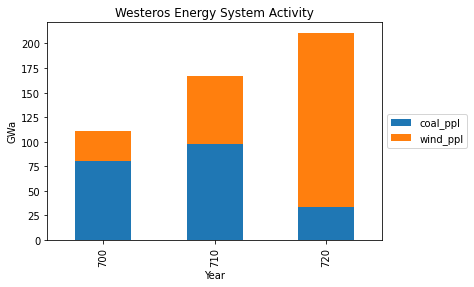

In [13]:
rep_base.set_filters(t=["coal_ppl", "wind_ppl"])
rep_base.get("plot activity")

#### Scenario: '*flexible_generation*'

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

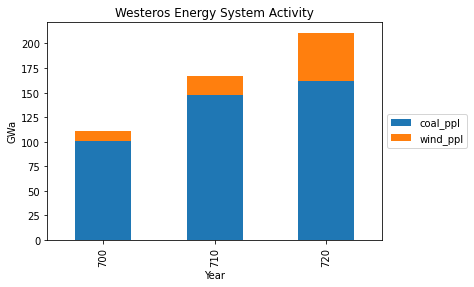

In [14]:
rep_scen.set_filters(t=["coal_ppl", "wind_ppl"])
rep_scen.get("plot activity")

### Impacts on emissions
***
As a further consequnece, the `carbon_tax`, which remains unchanged, does not result in emission reductions achieved in the '*carbon_tax*' scenario as shown below. We can see, that the emissions in 720 increase almost fivefold. Hence, adding the flexibility requirements to the scenario will require the `carbon_tax` to be increased  significantly to achieve the same emission reducitons. Alterantively, a technology which contributes more of its activity to the flexibility constraint, like a gas combustion turbine, could be added to the model.

#### Scenario: '*carbon_tax*'

In [15]:
base.var('EMISS', filters={'node': 'Westeros'})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,595.968587,0.0
1,Westeros,CO2,all,710,725.113435,0.0
2,Westeros,CO2,all,720,244.030692,0.0


In [16]:
#### Scenario: '*flexible_generation*'

In [17]:
scen.var('EMISS', filters={'node': 'Westeros'})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,745.631659,0.0
1,Westeros,CO2,all,710,1091.922760,0.0
2,Westeros,CO2,all,720,1195.439614,0.0


## Price
***
Prices of electricity increase most notably in 720, as can be seen from the two plots below comparing the prices of `light`. Note that in 700, the price of `light` decreases. This is because we have removed the dynamic growth constraint for `coal_ppl` in that year, allowing more electricity to be produced by the `coal_ppl` as opposed to the more expensive `wind_ppl`.

### Scenario: '*carbon_tax*'

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

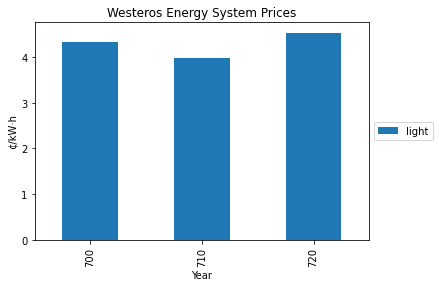

In [20]:
rep_base.set_filters(t=None, c=["light"])
rep_base.get("plot prices")

### Scenario: '*flexible_generation*'

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

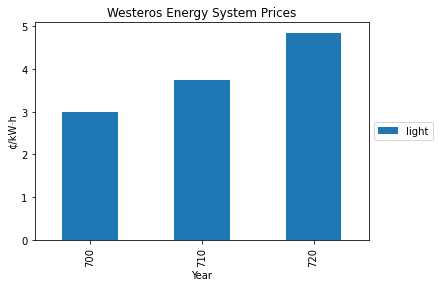

In [21]:
rep_scen.set_filters(t=None, c=["light"])
rep_scen.get("plot prices")

In [22]:
mp.close_db()